In [1]:
# import os
# os.environ["R_HOME"] = "/home/ld/anaconda3/envs/r/lib/R"
import sys

sys.path.append("../")
import scDesign3
import anndata as ad
import numpy as np

The R project used is located at D:/Code_env/R-4.3.1


In [ ]:
example_sce = ad.read_h5ad("test_data/VISIUM.h5ad")
example_sce.obs["test"] = ["test" for i in range(example_sce.n_obs)]
example_sce = example_sce[0:10, 0:10]
example_sce

construct_data interface


In [ ]:
## windows
bpparam = scDesign3.get_bpparam("SnowParam", stop_on_error=False)

## linux/mac
# bpparam = test.get_bpparam("MulticoreParam",stop_on_error = False)

In [ ]:
# test = scDesign3.scDesign3(n_cores=3,parallelization="bpmapply",bpparam=bpparam)
test = scDesign3.scDesign3(n_cores=1, parallelization="mcmapply")

In [ ]:
const_data = test.construct_data(
    anndata=example_sce,
    corr_formula="1",
    default_assay_name="counts",
    celltype="cell_type",
    spatial=["spatial1", "spatial2"],
)

In [ ]:
const_data["dat"]

In [ ]:
print(test.construct_data_res)

In [ ]:
# SummarizedExperiment = packages.importr('SummarizedExperiment')
# print(SummarizedExperiment.assay(test._sce,test._assay_use))
# print(SummarizedExperiment.colData(test._sce))
# print(SummarizedExperiment.rowData(test._sce))

fit_marginal interface


In [ ]:
marginal = test.fit_marginal(
    # data=const_data,
    mu_formula="s(spatial1,spatial2,bs='gp',k=2)",
    sigma_formula="1",
    family_use="nb",
    usebam=False,
    trace=True,
)

In [ ]:
test.fit_marginal_res.rx2("Gpsm1").rx2("fit").rx2("coefficients")[0] = 2

In [ ]:
print(test.fit_marginal_res.rx2("Gpsm1").rx2("fit").rx2("coefficients"))

In [ ]:
marginal

fit_copula interface


In [ ]:
copula = test.fit_copula(
    # family_use="nb",
    n_cores=1,
    copula="vine",
    parallelization="mcmapply",
    # parallelization="bpmapply",
    # bpparam=bpparam,
    important_feature="auto",
)

In [ ]:
print(copula)

extract paras interface


In [ ]:
paras = test.extract_para()

In [ ]:
print(paras)

simu_new interface


In [ ]:
new = test.simu_new()

In [ ]:
print(new)

scdesign3 interface


In [ ]:
whole_test = scDesign3.scDesign3(n_cores=1)
whole = whole_test.scdesign3(
    anndata=example_sce,
    corr_formula="1",
    default_assay_name="counts",
    celltype="cell_type",
    spatial=["spatial1", "spatial2"],
    mu_formula="s(spatial1,spatial2,bs='gp',k=2)",
    sigma_formula="1",
    family_use="nb",
    usebam=False,
    trace=True,
    important_feature="auto",
    # parallelization="mcmapply",
    # n_cores=1,
)

In [ ]:
print(whole_test.whole_pipeline_res)

In [ ]:
whole["marginal_list"]

perform_lrt interface


In [ ]:
test1 = scDesign3.scDesign3(n_cores=1, parallelization="mcmapply")
test2 = scDesign3.scDesign3(n_cores=1, parallelization="mcmapply")

In [ ]:
my_data = test1.construct_data(
    anndata=example_sce,
    default_assay_name="counts",
    celltype="cell_type",
    spatial=["spatial1", "spatial2"],
    corr_formula="cell_type",
)
my_data2 = test2.construct_data(
    anndata=example_sce,
    default_assay_name="counts",
    celltype="cell_type",
    spatial=["spatial1", "spatial2"],
    corr_formula="1",
    ncell=10,
)

In [ ]:
test1.fit_marginal(
    # data=const_data,
    mu_formula="1",
    sigma_formula="1",
    family_use="nb",
    usebam=False,
)
marginal1 = test1.fit_marginal_res

test2.fit_marginal(
    # data=const_data,
    mu_formula="s(spatial1,spatial2,bs='gp',k=3)",
    sigma_formula="1",
    family_use="nb",
    usebam=False,
)
marginal2 = test2.fit_marginal_res

In [ ]:
marginal1 = {key: value.rx2("fit") for key, value in marginal1.items()}
marginal2 = {key: value.rx2("fit") for key, value in marginal2.items()}

In [ ]:
scDesign3.perform_lrt(marginal2, marginal1)

plot_reduceddim interface


In [2]:
pan = ad.read_h5ad("test_data/PANCREAS.h5ad")
pan = pan[:, 0:30]
pan.layers['log_transformed'] = np.log1p(pan.X)

In [3]:
plt_test = scDesign3.scDesign3(n_cores=1)
example_simu = plt_test.scdesign3(
    anndata=pan,
    default_assay_name="counts",
    celltype="cell_type",
    pseudotime="pseudotime",
    mu_formula="s(pseudotime, k = 10, bs = 'cr')",
    sigma_formula="1",
    family_use="nb",
    usebam=False,
    corr_formula="1",
    copula="gaussian",

)

R[write to console]: Input Data Construction Start

R[write to console]: Input Data Construction End

R[write to console]: Start Marginal Fitting

R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian

R[write to console]: Converting End

R[write to console]: Copula group 1 starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction

R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts

R[write to console]: New Data Generating End



In [4]:
simu_pan = ad.AnnData(X=example_simu["new_count"].T,obs=example_simu["new_covariate"])
simu_pan.layers['log_transformed'] = np.log1p(simu_pan.X)
simu_pan

AnnData object with n_obs × n_vars = 2087 × 30
    obs: 'cell_type', 'pseudotime'
    layers: 'log_transformed'

R[write to console]: Warning in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE,  :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.




    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

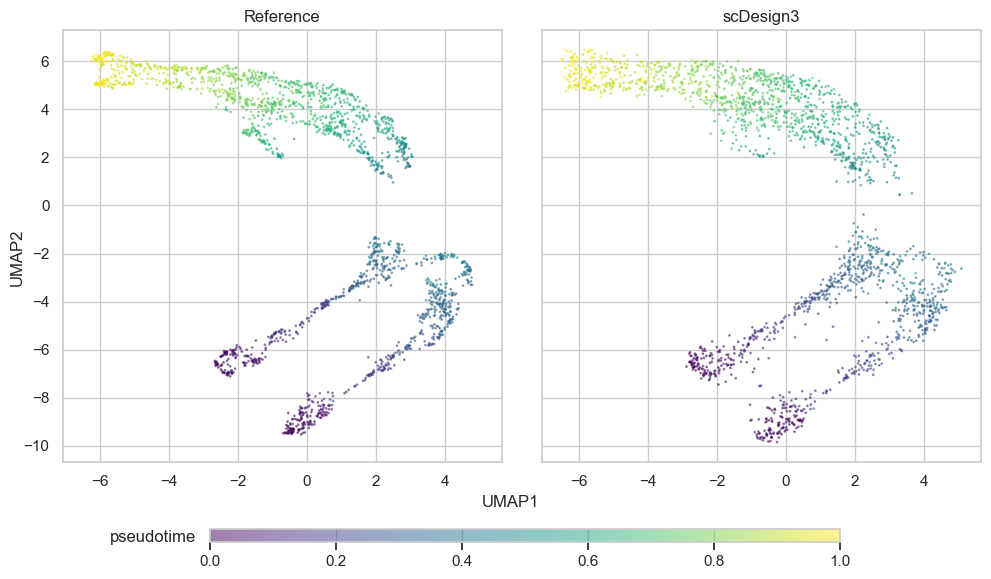

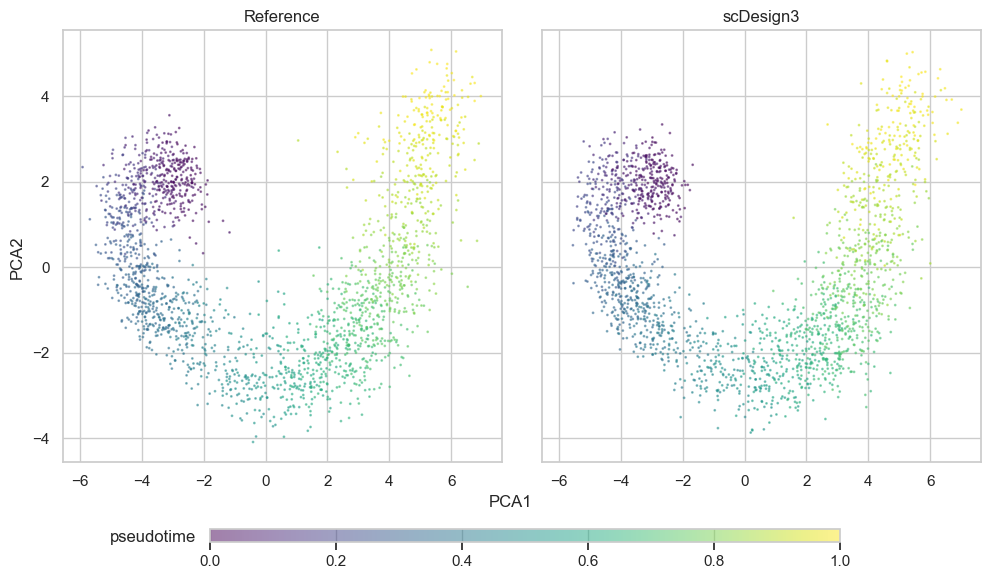

In [5]:
plt_res = scDesign3.plot_reduceddim(
    ref_anndata=pan,
    anndata_dict={"0": simu_pan},
    name_list=["Reference", "scDesign3"],
    assay_use="log_transformed",
    if_plot=True,
    color_by="pseudotime",
    n_pc=20,
    point_size=5,
)